In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import json
import cv2
import urllib
import textract
import pytesseract
import colorsys
import deepface
from deepface import DeepFace

In [2]:
def read_csv(title):
    return pd.read_csv(title, sep=',', encoding='cp1252', engine='python')

def transform_df(df):
    del df['Unnamed: 0']
    df['comments_disabled'] = df['comments_disabled'].transform(lambda x: 0 if x=='False' else 1)
    df['ratings_disabled'] = df['ratings_disabled'].transform(lambda x: 0 if x=='False' else 1)
    return df

def get_category(df, file_name):
    categories_dict = {}
    with open(file_name) as file:
        cats = json.load(file)
        for x in cats['items']:
            categories_dict[x['id']] = x['snippet']['title']

    df['category_name'] = df['categoryId'].transform(lambda x: "Unknown" if x=='False' or not x or pd.isna(x) or str(int(float(x))) not in categories_dict else categories_dict[str(int(float(x)))])
    return df

def symbolic_transformer(df, name):
    return df['title'].transform(lambda x: len([y for y in x if y==name]) if x else 0)

def transform_df_symbols_and_title_nuissances(df):
    df['title_length'] = df['title'].transform(lambda x: None if x is None else len(x))
    df['description_length'] = df['description'].transform(lambda x: 0 if not x else len(str(x)))
    df['nr_tags'] = df['tags'].transform(lambda x: 0 if x is None or x=='[None]' else len(x.split('|')))
    df['link_amount'] = df['description'].transform(lambda x: 0 if not x else str(x).count('://'))
    
    df['interpunction_title'] = df['title'].transform(lambda x: len([y for y in x if y in [',', ';', '`', "'", '"', '.', '!', '?', ':']]) if x else 0)
    df['interpunction_exclamation'] = symbolic_transformer(df, '!')
    df['interpunction_question'] = symbolic_transformer(df, '?')
    df['interpunction_dot'] = symbolic_transformer(df, '.')
    df['interpunction_comma'] = symbolic_transformer(df, ',')
    
    df['screams'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90]) if x else 0)
    df['screams_to_normal_proportion'] = df['title'].transform(lambda x: len([y for y in x if ord(y)>=65 and ord(y)<=90])/len(x) if x else 0)
    return df

def transform_dates(df):
    day_const = (3600*24)
    df['publishedAt_modern'] = df['publishedAt'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    df['trending_date_modern'] = df['trending_date'].transform(lambda x: None if (not x or len(x)<8) else datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
    
    df['weekday_published'] = df['publishedAt_modern'].transform(lambda x: x.weekday())
    df['time_diff'] = (df['trending_date_modern']-df['publishedAt_modern']).transform(lambda x:x.total_seconds()/(day_const))
    return df

In [3]:
US95 = read_csv('USdata95.csv')
GB95 = read_csv('GBdata95.csv')

primal_gb = [GB95]
primal_us = [US95]
primal_gb = [get_category(x, 'GB_category_id.json') for x in primal_gb]
primal_us = [get_category(x, 'US_category_id.json') for x in primal_us]

elements = [*primal_gb]
elements.extend(primal_us)
elements = [transform_df(x) for x in elements]


elements = [transform_df_symbols_and_title_nuissances(x) for x in elements]
elements = [transform_dates(x) for x in elements]
all_movies = pd.concat(elements)
post_movies = all_movies.copy()
neo_movies = post_movies.sort_values(by='trending_date_modern').drop_duplicates(subset=['video_id'])

In [38]:
amount = 100
download = False

In [ ]:
if download:
    for i, x in enumerate(neo_movies['thumbnail_link'][:amount]:
        try:
            urllib.request.urlretrieve(x, f'./images/file_{i}.jpg')
        except:
            print(f'Unable to show image nr {i}')
            pass

In [ ]:
images = [cv2.imread(f'./images/file_{i}.jpg', cv2.IMREAD_COLOR)[...,::-1] for i in range(amount) if i!=95]

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

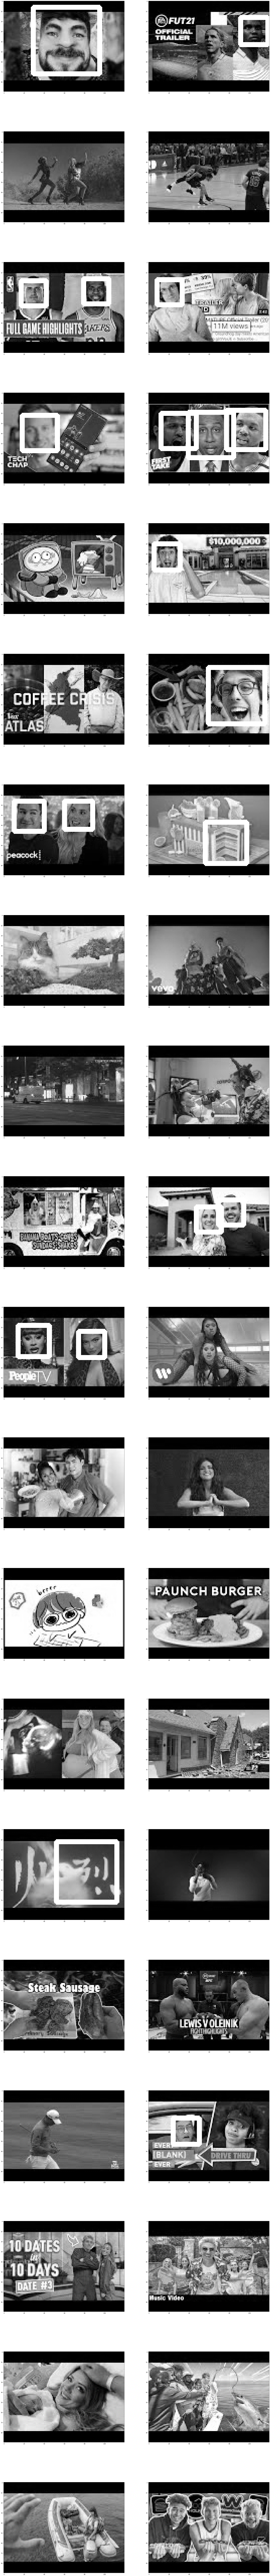

In [54]:
x_size, y_size=2, 20
fig, ax=plt.subplots(y_size, x_size, figsize=(x_size*18, y_size*18))

for i in range(0, y_size*x_size):
    img = images[i]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.06,
        minNeighbors=2,
        flags=cv2.CASCADE_SCALE_IMAGE
    )# For each face
    
    #detector_name = "opencv"
    #detector = deepface.detectors.FaceDetector.build_model(detector_name) #set opencv, ssd, dlib, mtcnn or retinaface
    #obj = deepface.detectors.FaceDetector.detect_faces(detector, detector_name, img)
    #for face in obj:
        #o2 = np.asarray(face[0])
        #plt.imshow(o2)
        #plt.show()
        #analyze = DeepFace.analyze(o2, actions=['age'])
        #print(analyze)
    
    for (x, y, w, h) in faces: 
        # Draw rectangle around the face
        cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 255, 255), 3)
        face = img[x:x+w,y:y+h]
        #analyze = DeepFace.analyze(img[x:x+w,y:y+h]/255, actions=['age'])
        #print(analyze)
    
    ax[i//x_size][i%x_size].imshow(gray, cmap="gray")

In [58]:
amount_faces=[]
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=2,
        flags=cv2.CASCADE_SCALE_IMAGE
        )
    amount_faces.append(len(faces))
    
print(amount_faces)

[1, 1, 0, 0, 0, 0, 1, 3, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 3, 0]


In [59]:
mx_af = max(amount_faces)
count_amount_faces = [0]*(mx_af+1)
for x in amount_faces:
    count_amount_faces[x] += 1

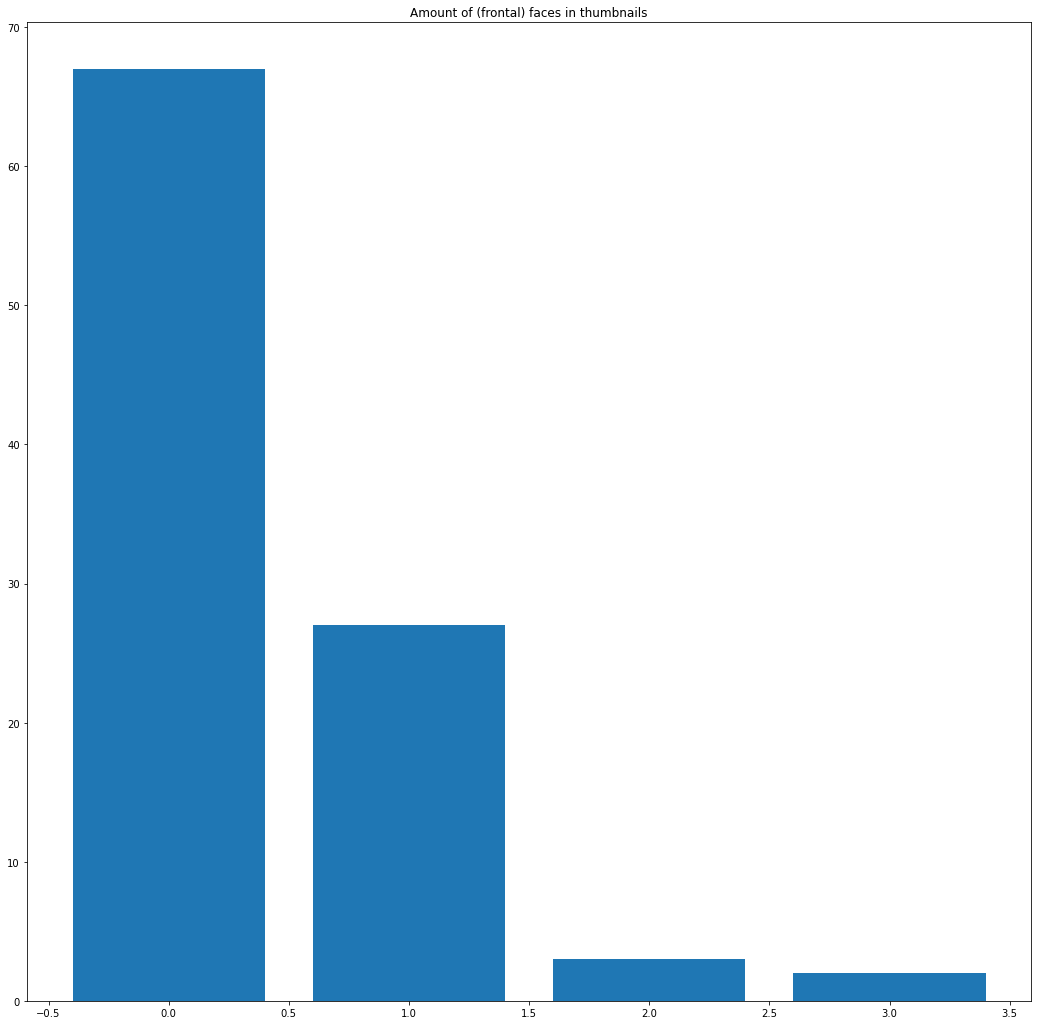

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(18,18))
ax.bar(list(range(mx_af+1)), count_amount_faces)
ax.set_title('Amount of (frontal) faces in thumbnails')
plt.show()

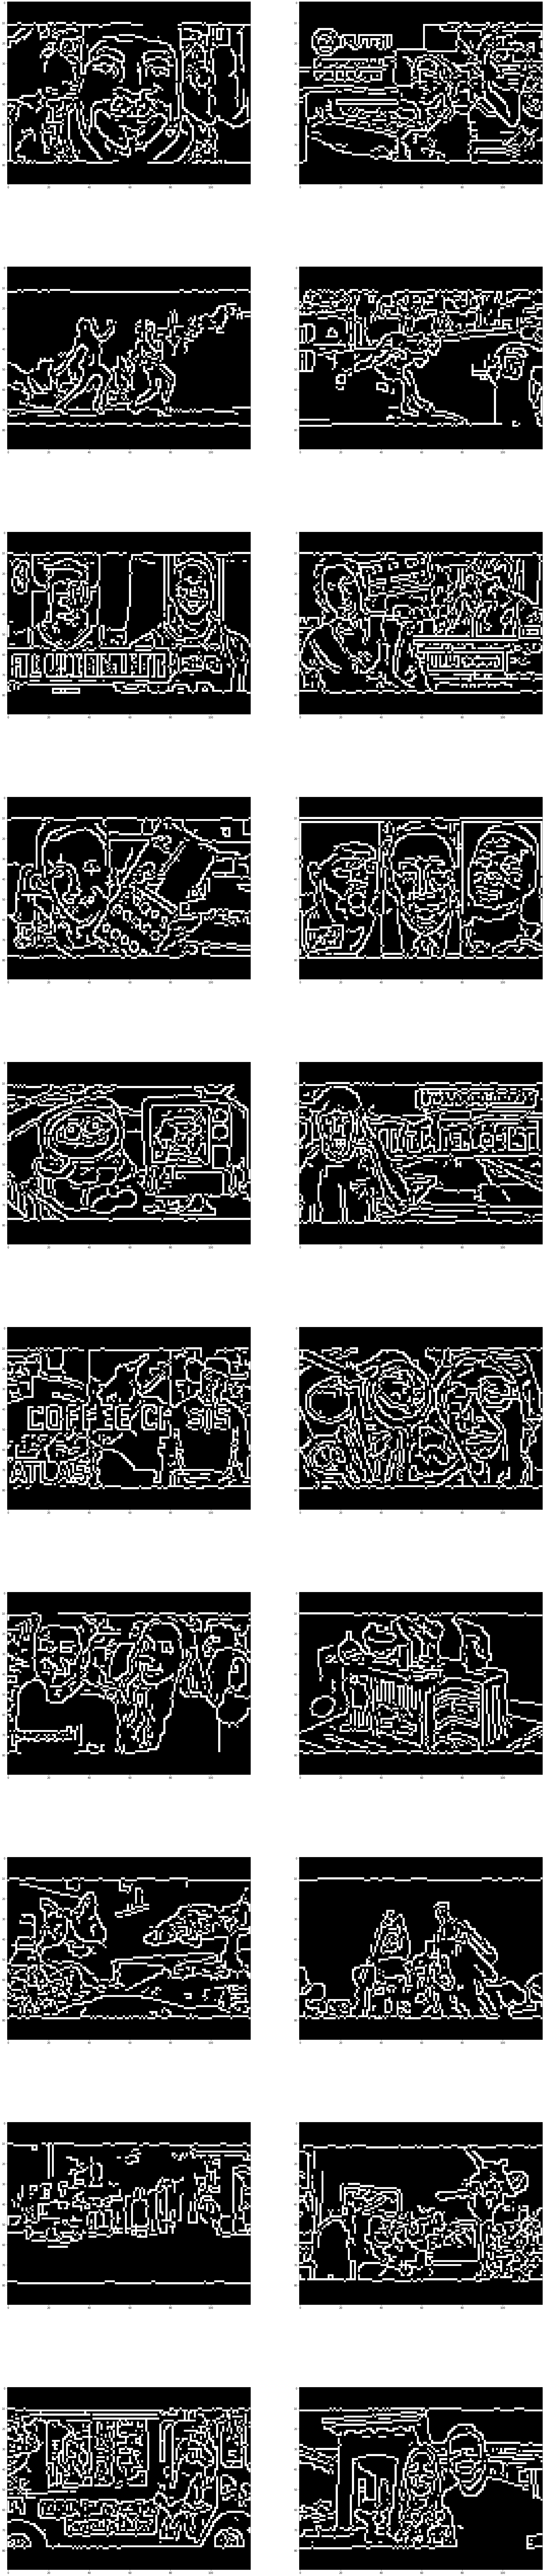

In [61]:
x_size, y_size=2, 10
fig, ax=plt.subplots(y_size, x_size, figsize=(x_size*18, y_size*18))

for i in range(y_size*x_size):
    img = cv2.imread(f'./images/file_{i}.jpg', cv2.IMREAD_COLOR)    
    img_edge = cv2.Canny(img,100,200)
    ax[i//x_size][i%x_size].imshow(img_edge, cmap="gray")

In [62]:
amount_action = []
for img in images:
    img_edge = cv2.Canny(img,100,200)
    summa = sum([sum(x) for x in img_edge])//255
    amount_action.append(summa/(img_edge.shape[0]*img_edge.shape[1]))

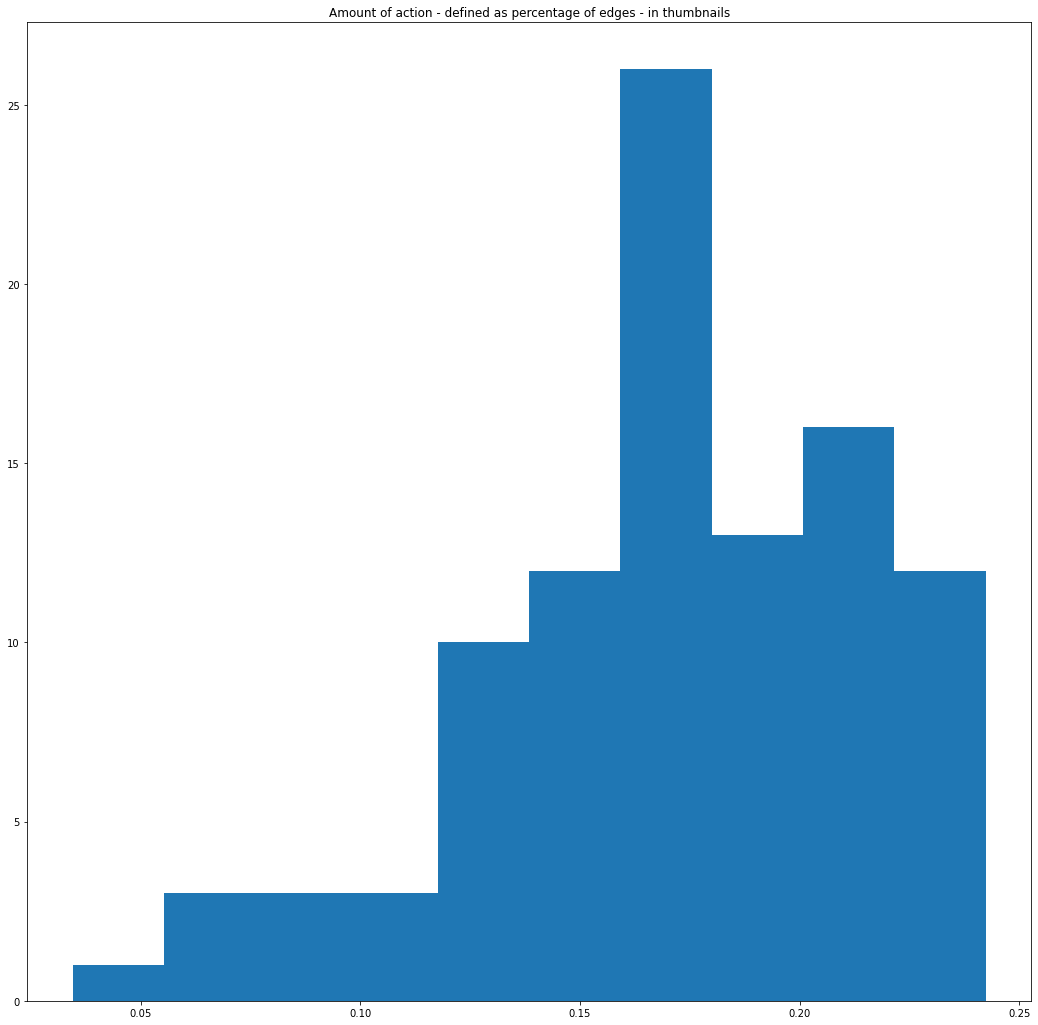

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(18,18))
ax.hist(amount_action)
ax.set_title('Amount of action - defined as percentage of edges - in thumbnails')
plt.show()

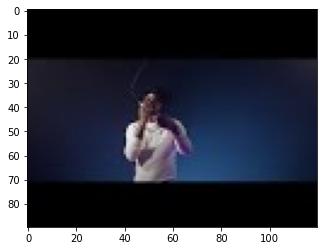

In [65]:
mn = min(amount_action)

min_img = [i for i,x in enumerate(amount_action) if x==mn][0]
plt.imshow(images[min_img])
plt.show()

In [49]:
def linearize_color(color):
    linear = []
    for x in color:
        linear.extend(x)
    linear = sorted(linear)
    return linear

mean_color = [[], [], []]
for img in images:
    colors = [img[:,:,i] for i in range(3)]
    linear = [linearize_color(colors[i]) for i in range(3)]
    _ = [mean_color[i].append(sum(linear[i])/len(linear[i])) for i in range(3)]

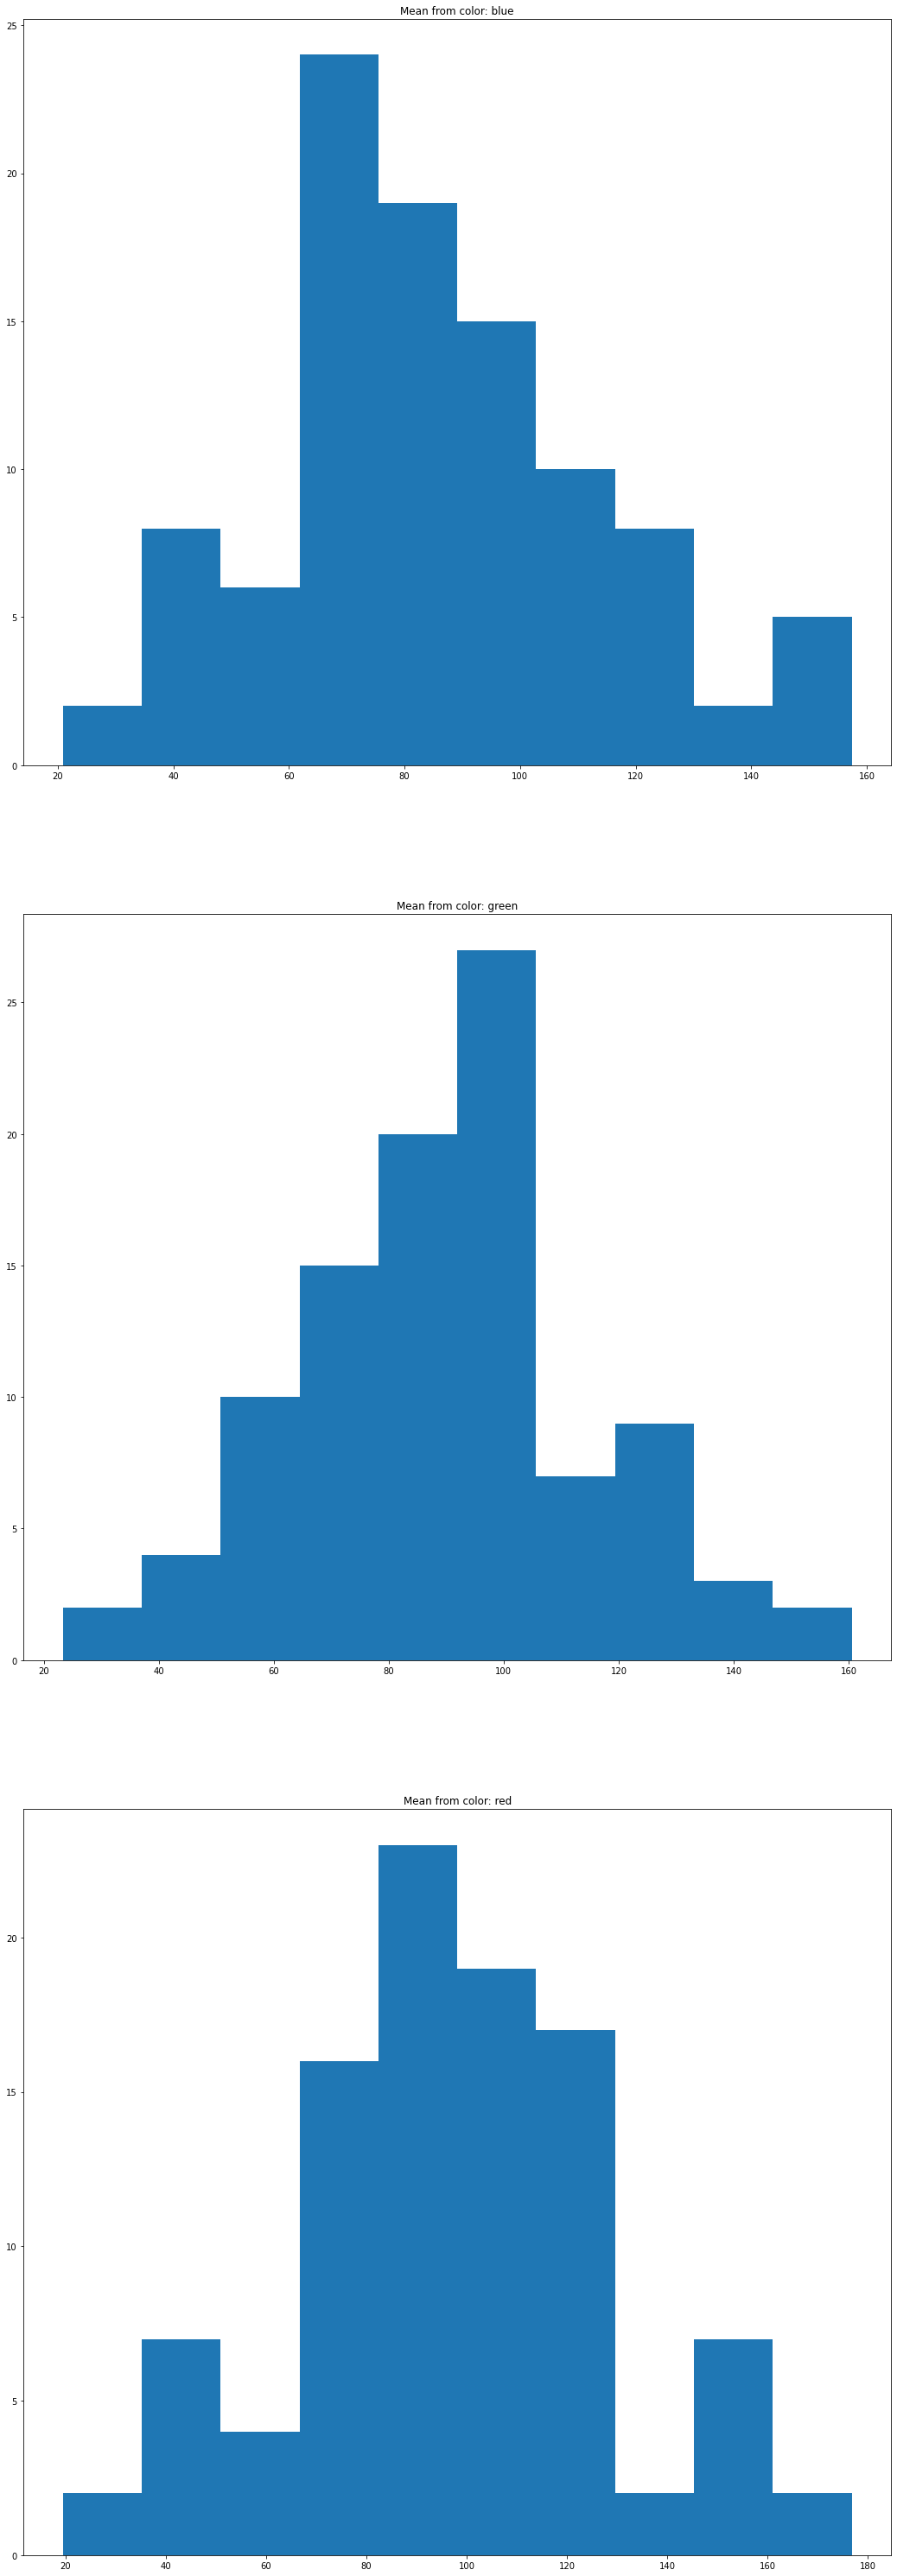

In [55]:
fig, ax = plt.subplots(3, 1, figsize=(18,3*18))
cols = {0:'blue', 1:'green', 2:'red'}

for i in range(3):
    ax[i].hist(mean_color[i])
    ax[i].set_title(f'Mean from color: {cols[i]}')
plt.show()

In [87]:
mean_color = [[], [], []]
for img in images:
    hsv_img = np.asarray([[colorsys.rgb_to_hsv(*[z/255 for z in x]) for x in y] for y in img])
    
    colors = [hsv_img[:,:,i] for i in range(3)]
    linear = [linearize_color(colors[i]) for i in range(3)]
    _ = [mean_color[i].append(sum(linear[i])/len(linear[i])) for i in range(3)]

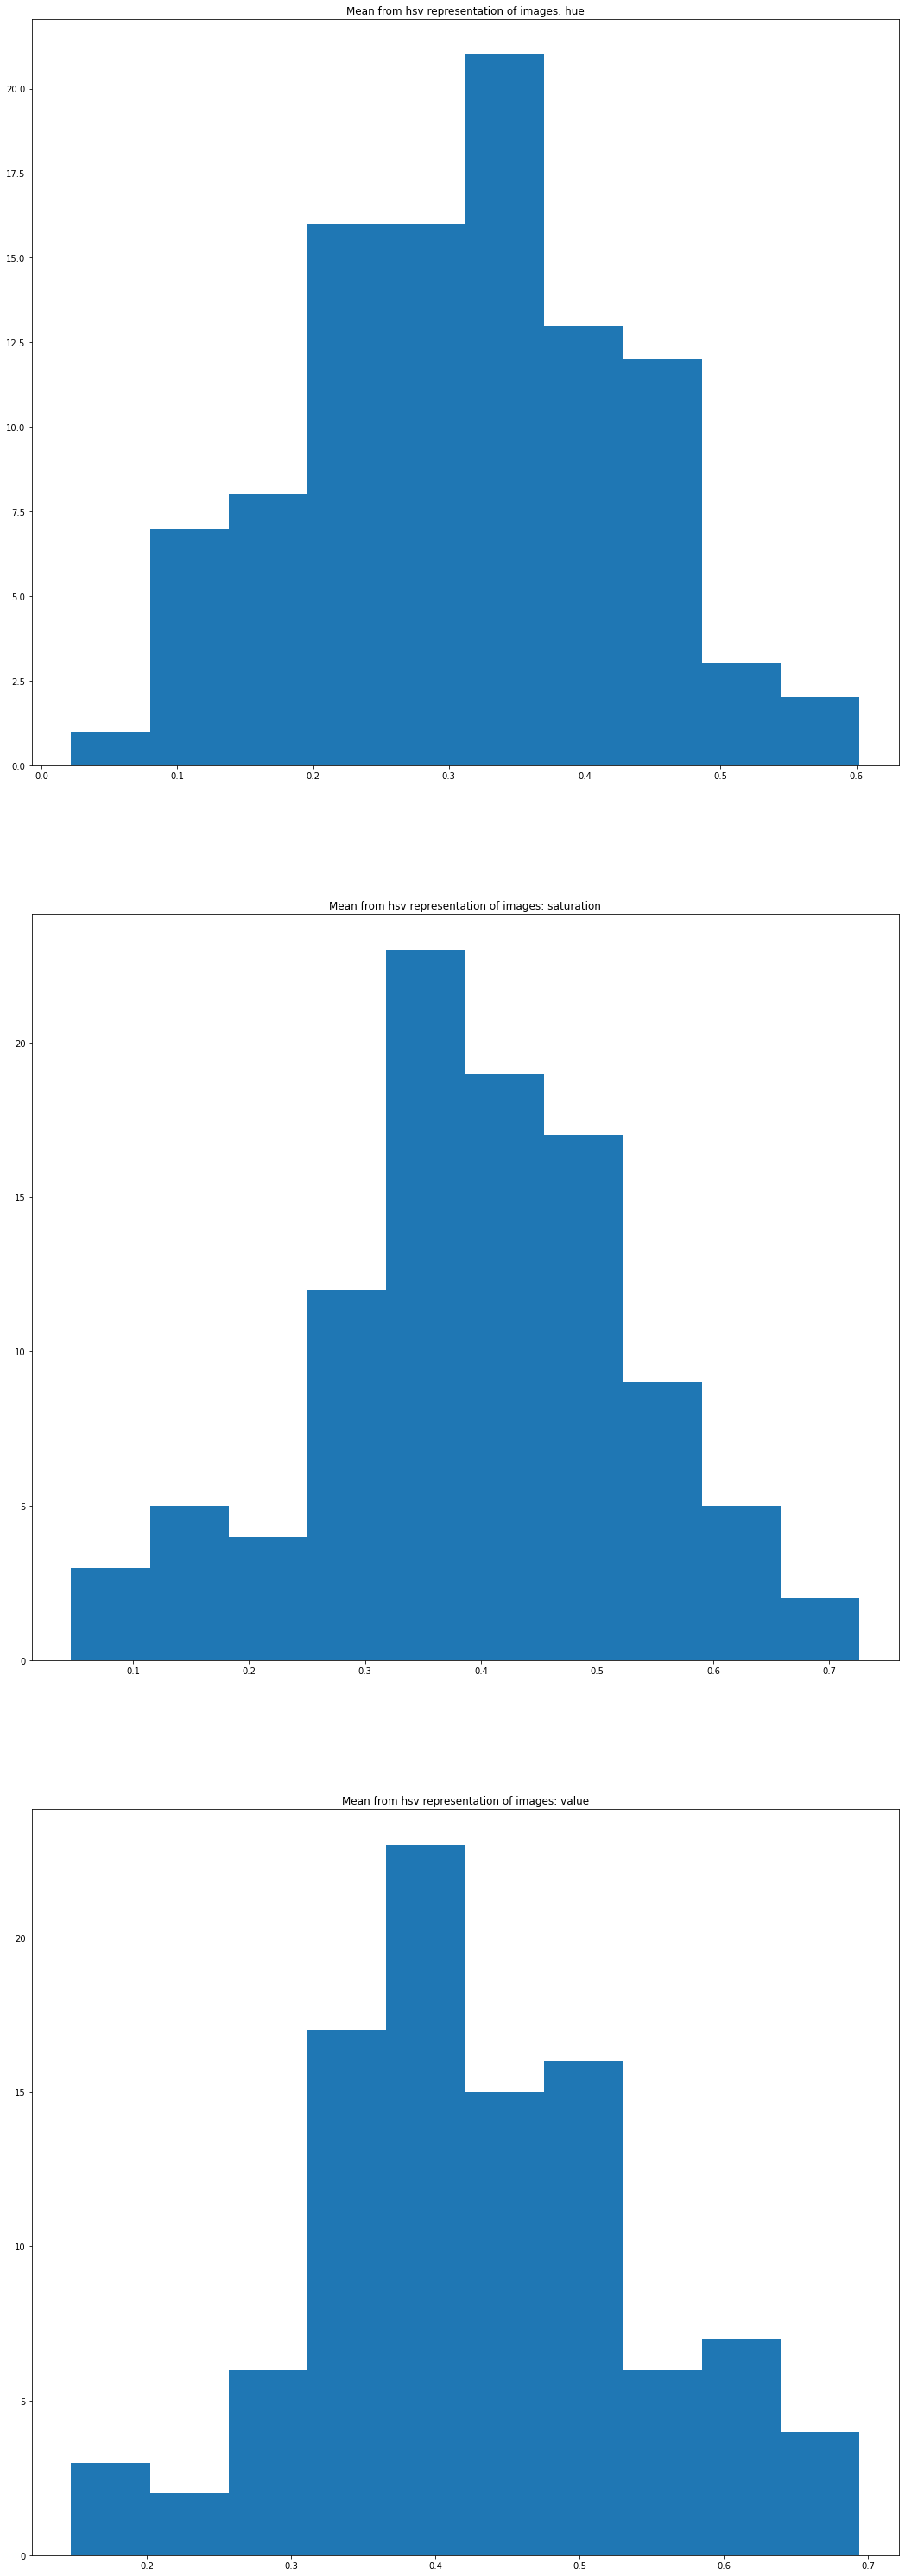

In [89]:
fig, ax = plt.subplots(3, 1, figsize=(18,3*18))
cols = {0:'hue', 1:'saturation', 2:'value'}

for i in range(3):
    ax[i].hist(mean_color[i])
    ax[i].set_title(f'Mean from hsv representation of images: {cols[i]}')
plt.show()

In [90]:
mean_color = [[], [], []]
for img in images:
    proper_img = img[11:79,:,:]
    hsv_img = np.asarray([[colorsys.rgb_to_hsv(*[z/255 for z in x]) for x in y] for y in proper_img])
    
    colors = [hsv_img[:,:,i] for i in range(3)]
    linear = [linearize_color(colors[i]) for i in range(3)]
    _ = [mean_color[i].append(sum(linear[i])/len(linear[i])) for i in range(3)]

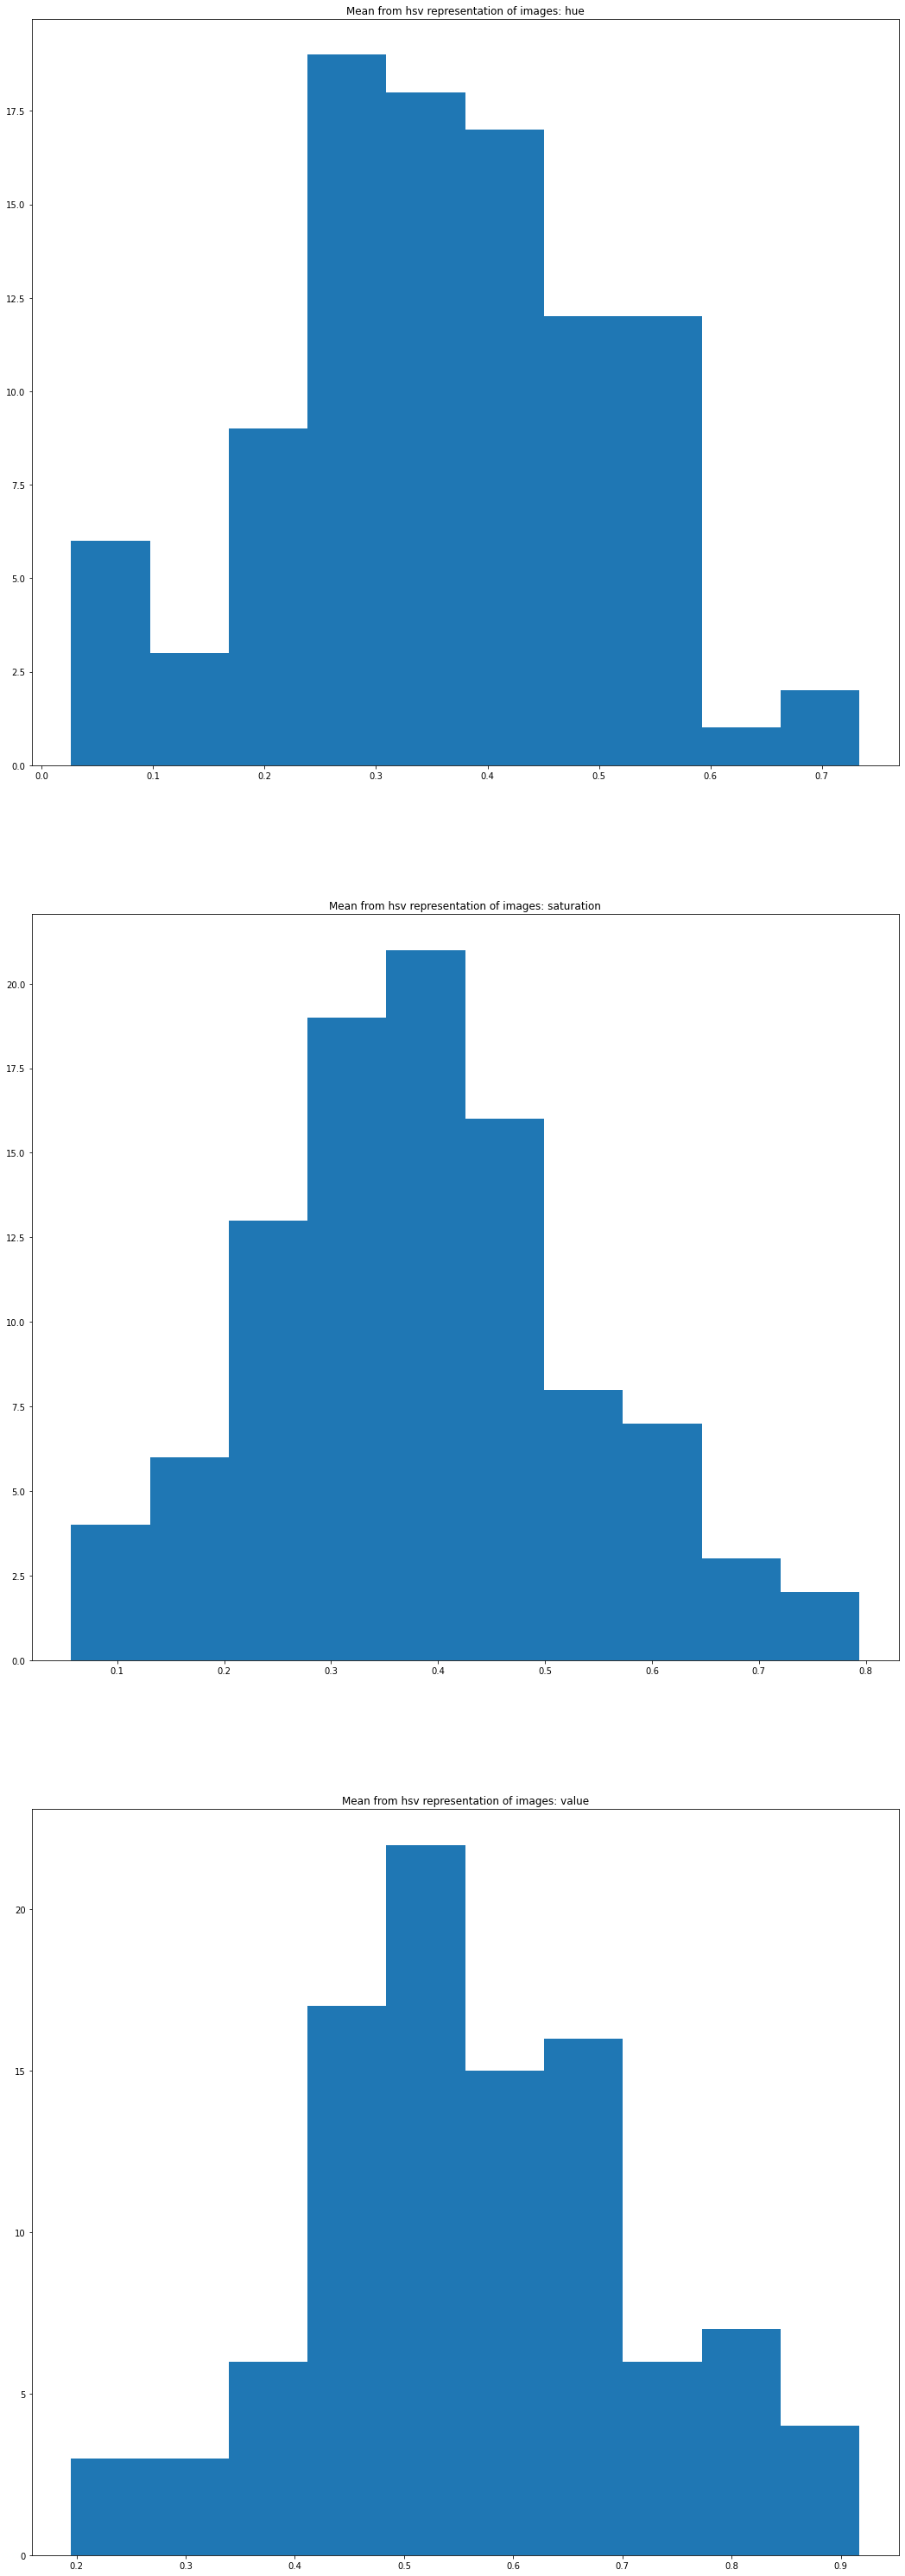

In [91]:
fig, ax = plt.subplots(3, 1, figsize=(18,3*18))
cols = {0:'hue', 1:'saturation', 2:'value'}

for i in range(3):
    ax[i].hist(mean_color[i])
    ax[i].set_title(f'Mean from hsv representation of images: {cols[i]}')
plt.show()

In [39]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [41]:
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

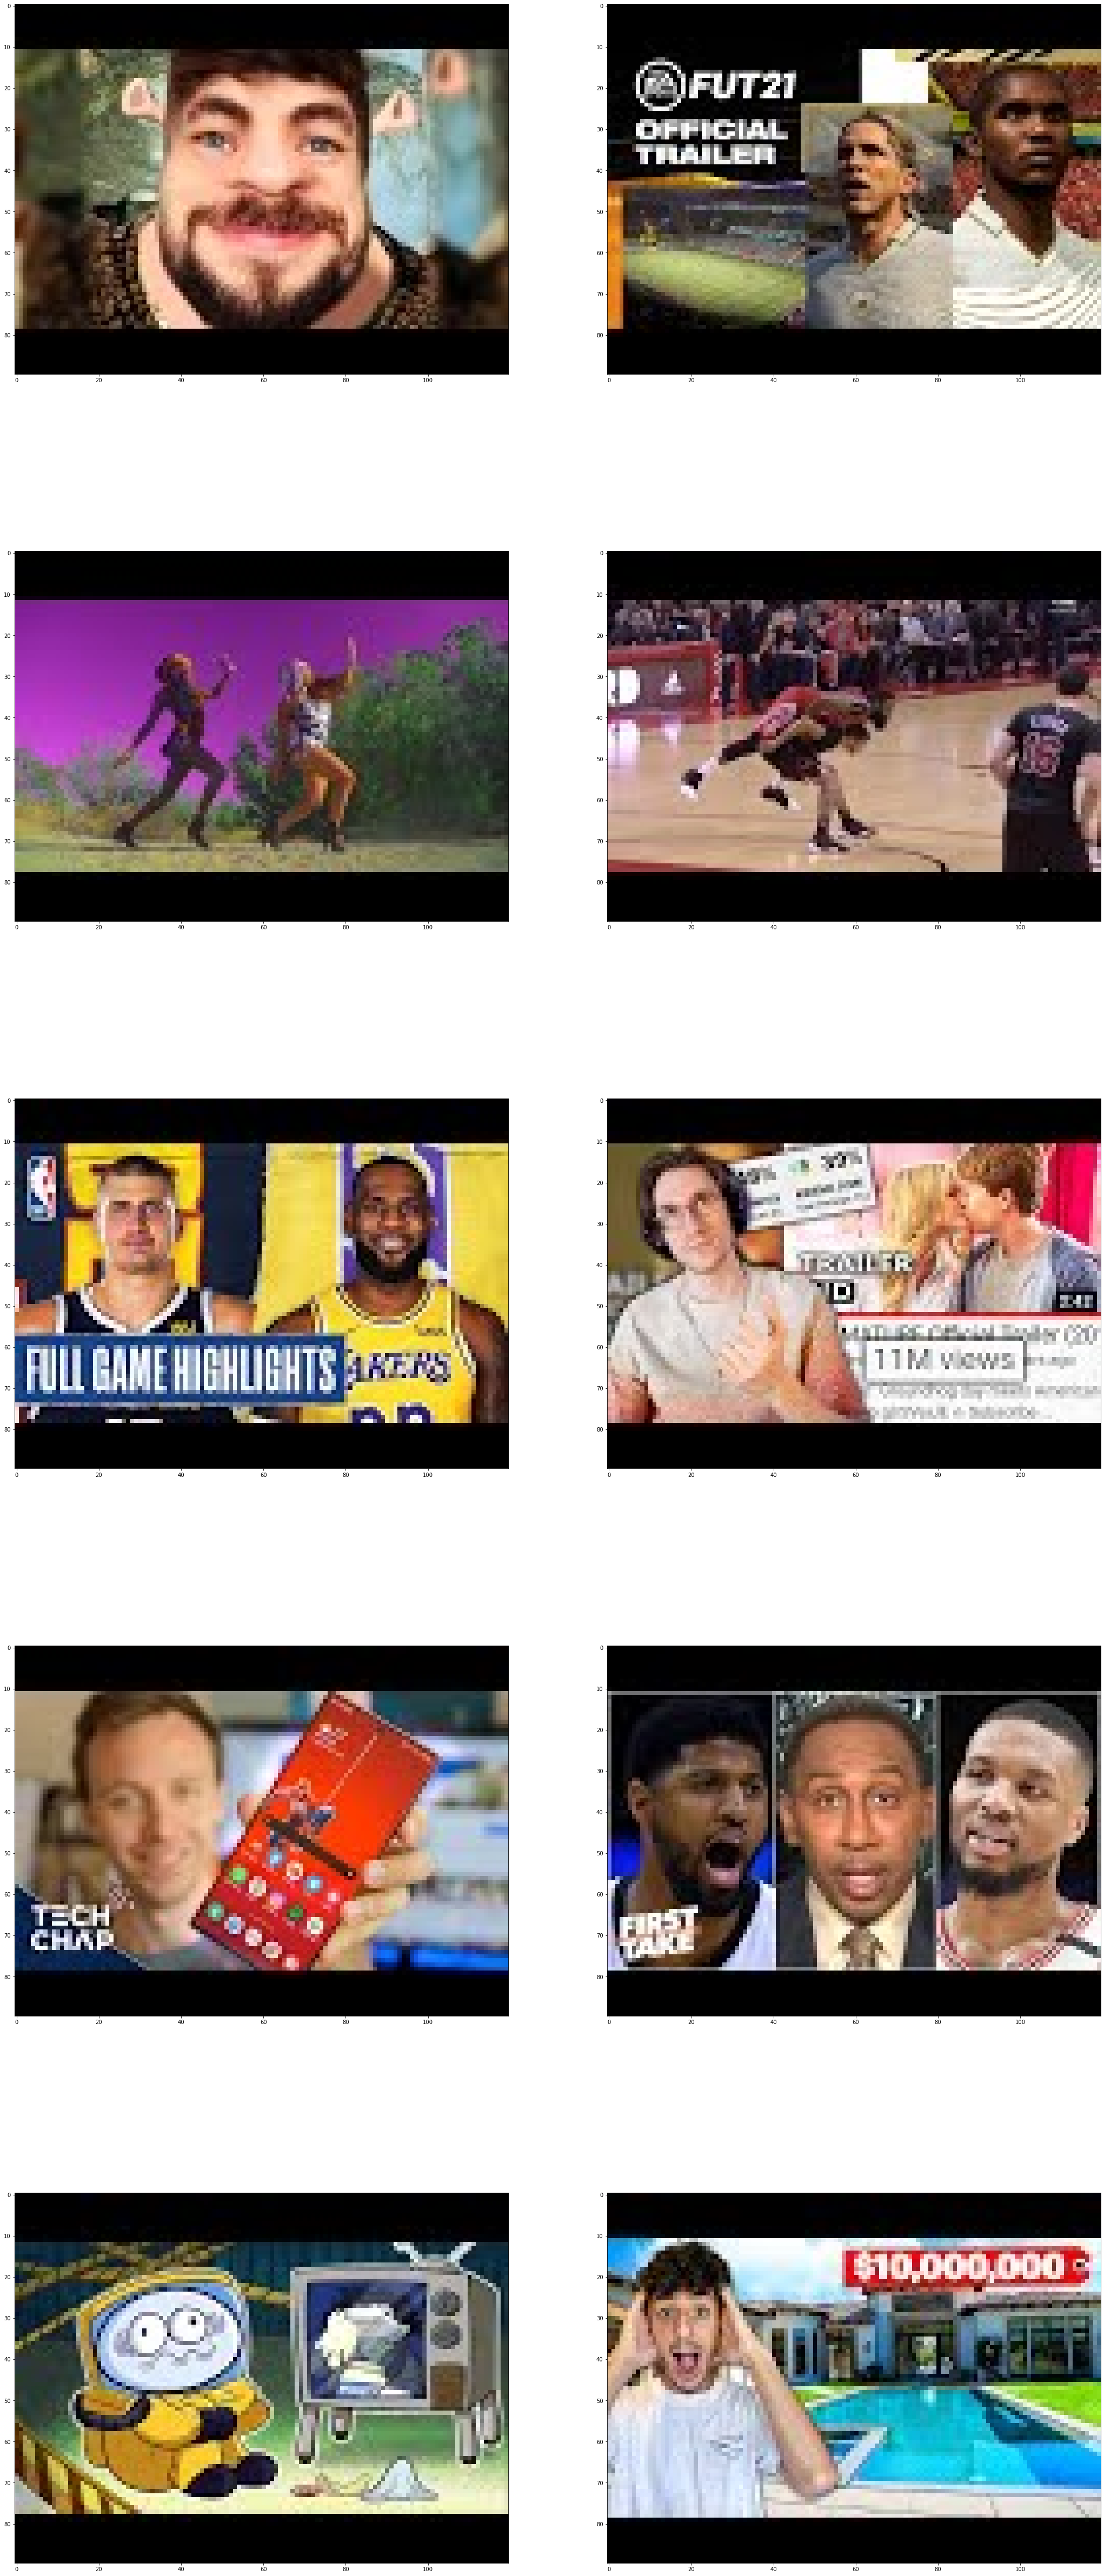

In [67]:
fig, ax=plt.subplots(5, 2, figsize=(2*18, 5*18))
for i in range(10):
    img = images[i]
    ax[i//2][i%2].imshow(img)
plt.show()